<a href="https://colab.research.google.com/github/compi1234/spchlab/blob/main/lab09_hmm2/viterbi_ex1.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Google Colab" title="Open in Google Colab"></a> 

# Viterbi Alignment - Exercise 1

The Viterbi algorithm is ideally suited to align speech with a given pronunciation that should be expressed as a sequence of speech units known in the acoustic model of an HMM, typically phonemes.  
The Viterbi alignment relies on the "beads-on-a-string" (or left-to-right) model of pronunciation,
in which an utterance may be viewed as a strict sequence of underlying phonetic units.   
 
In a vanilla Viterbi alignment the presumed pronunciation (phonetic transcription) is converted into a left-to-right HMM graph.   
This notebook also contains code to implement Viterbi alignments with extra flexibility to allow for sloppy pronunciations (skipping phones), pronunciation variants, ...  by adding extra arcs on top of the baseline left-to-right model.   Hence the mere alignment is turned into a  mini recognizer over a (very) small graph. 

The transcriptions to be aligned against can be provided in a number of different ways:   
- hand made phonetic transcriptions provided by human annotators (e.g. as available in TIMIT)   
- canonical transcriptions by expanding a word transcription to a phonetic transcription using a phonetic dictionary     
- ad hoc transcriptions (provided by you)  

In [19]:
####################################################################################
### RUNNING THIS CELL FIRST ##########
### will suppresses warnings on memory leaks, deprecation warnings and future warnings 
### It is brute force .  
### Best is not to run it when you want to debug code or new installations
import os, warnings 
os.environ["OMP_NUM_THREADS"] = '2'  
warnings.filterwarnings("ignore")
####################################################################################

In [20]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import importlib
import urllib.request
import pickle
import gzip
import re
import torch
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[15:55]
pd.set_option("display.precision", 2)

# pyspch
import pyspch
import pyspch.core as Spch
import pyspch.display as Spd
import pyspch.stats.probdist as Densities
import pyspch.stats.libhmm as libhmm
from pyspch.stats import GMM, Prob
import pyspch.nn

# device
torch.manual_seed(0)
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

from pyspch.core.utils_x import plot_probs, get_test_file

In [4]:
### SOME UTILITIES
######################

def select_phones_idx(phn_lists,phn_set,SORTED=False):
    ''' 
    creates a unique list of phones from a set of phone lists
    return the unique list AND their indices in a global phone set
    the order of appearance is preserved or sorted according to phn_set
    '''
    if not isinstance(phn_lists,tuple):
        phn_lists = ([],phn_lists)
    combined_list = []
    for phn_list in phn_lists:
        combined_list.extend(list(phn_list))
    select_list = []
    for phn in combined_list:
        if phn not in(select_list): select_list.append(phn) # list(np.unique(select_list))
    if SORTED:
        select_list = [ phn  for phn in phn_set if (phn in select_list) ] # sorted(select_list)
    select_idx = [phn_set.index(phn) for phn in select_list]
    return(select_list,select_idx)

def make_hmm(phn_seq,phn_set,init_states=None, end_states=None,l2r=1.0,eps=0.0,skip=0.0,extra_arcs=None):
    ''' 
    Make an HMM model from a sequence of phonemes (possibly non unique).
    This routine starts by building a left-to-right model based on the sequence

    The model may be made to deviate from strict L2R in several ways by adding:
    - skip arcs over all phones in the sequence
    - some extra arcs
    - non-zero probabilities on all ergodic arcs

    By default the only entry point into the graph is the first state and the terminal state will be enforced to be the last of the sequence

    Parameters:
    ===========
        - phn_seq     phone sequence (list)
        - phn_set     the complete phone set known to the HMM acoustic model (set)
        - l2r         transition probability of the l2r arcs (float) 
        - eps         probability that can be assigned to all ergodic (NON L2R) arcs (float, default=0.0)
        - skip        probability assigned to all arcs that make a single skip in the canonical phone sequence (float, default=0.0)
        - extra_arcs  additional arcs that can be added to the graph (list of [i1,i2] nodes; i1 and i2 are indexes in the state sequence)
        - init_states  list of state numbers where the graph can be entered (default = None, implies first phone only or "ALL" or list)
        - end_states   list of state numbers where the graph can be exited (default = None, implies last phone only or "ALL" or list)
        
    Returns:
    ========
        - obs_indx    points to the index of the observation probability function (list of length len(phn_states))
        - trans_mat   HMM transition matrix derived from the graph
        - init_mat    HMM init matrix
        - end_states  HMM admissible end states

        DISCLAIMER: The probability matrices are floats that are all less than 1.0 (making them suitable for the HMM package) 
                    but extra normalization is required to turn them into true probabilities
                    
    '''
    phn2idx = {lab: i for i, lab in enumerate(phn_set)}
    n_states = len(phn_seq)
    obs_indx = np.zeros(n_states,dtype='int')
    trans_mat = np.eye(n_states,dtype='float32')

    for i  in range(n_states): 
        obs_indx[i] = phn2idx[phn_seq[i]]


    # create init_mat matrix of entry points
    init_mat = np.zeros(n_states,dtype='float64')
    if init_states is None:
        init_states = np.array([0])
    elif init_states == "ALL":
        init_states = np.arange(n_states)        
    # else assume that it is a list
    for i in init_states:
        init_mat[i] = 1.0
        
    # add left-to-right and skip arcs
    for i in range(n_states-1):
        trans_mat[i,i+1] = np.maximum(l2r,trans_mat[i,i+1])
        if i+2 < n_states:
            trans_mat[i,i+2] = np.maximum(eps,skip)
                
    # create list of end_states
    if end_states is None:
        end_states = np.array([n_states-1])
    elif end_states == "ALL":
        end_states = np.arange(n_states)
    # else assume that it is a list

    
    # add extra arcs with the same transition probability as the LR arcs
    if extra_arcs is not None:
        for arc in extra_arcs:
            (i,j) =  arc[0],arc[1]
            trans_mat[i,j] = np.maximum(l2r,trans_mat[i,j])
        
    # set eps probabilities on all 'other' arcs
    trans_mat = np.maximum(eps,trans_mat)
    init_mat = np.maximum(eps,init_mat)
     
    return(obs_indx,trans_mat,init_mat,end_states)


In [5]:
# Lexicon, word, graph, .. utilities
#
# load a mini CMU lexicon from pyspch/data
lexicon = { k:v.split() for k,v in Spch.load_data("lexlm/mini_lexicon.txt",maxcols=1)}

def wrds_2_phns(wrds,lexicon,glue=None,CLEANUP=True):
    '''
    expand list of words (wrds) to list of phones with glue symbol in between
    CLEANUP=True eliminates duplicate successive symbols
    '''
    if glue is None:
        phns = []
    else :
        phns = [glue]
    for wrd in wrds:
        for phn in lexicon[wrd]:
            phns.append(phn)
        if glue is not None: phns.append(glue)
    if CLEANUP:
        prev = ""
        clean_phns = []
        for phn in phns:
            if phn != prev:
                clean_phns.append(phn)
                prev = phn
        return(clean_phns)
    else:
        return(phns)

def make_bplabels(backptrs,labels,values=None,fmt='{}'):
    '''
    make a 2D array of back pointer labels
    add the values to the labels if an array of equal size is given 
    '''
    (N,M) = backptrs.shape
    if values is None:
        bplabels = np.full((N,M),"",dtype="<U6")
    else:
        bplabels = np.full((N,M),"",dtype="<U12")
        
    for i in range(N):
        for j in range(M):
            if backptrs[i,j] !=-1:
                if values is None:
                    bplabels[i,j] = labels[ backptrs[i,j] ]
                else:
                    bplabels[i,j] = ">"+labels[ backptrs[i,j] ]+ "\n  " + fmt.format(values[i,j])              
    return(bplabels)

## 1. Import Acoustic Models

You can use 2 pretrained models trained on the TIMIT database.  They both use MFCC cepstral features and have models trained for phoneme classification (i.e. single state phonemes)

1. **GMM Model**
- Feature Extraction:  MFCC26=  MFCC13 + Deltas + mean-variance normalization
- model: S41_D26_G64_FULL_1.pkl  G64=64 Gaussians, S41= 41 classes/states, D26 = 26 dim features, (FrameRecog: 56%)

2. **DNN Model**
- Feature Extraction: MFCC39:  MFCC13 + Deltas + Delta_Deltas + mean-variance normalization
- splicing of 11 frames with stride 2  (receptive field of over 200 msec)
- model: an MLP with 3 hidden layers of size 429(IN) x 1024(H1) x 768(H2) x 512(H3) x 41(OUT)

In [6]:
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/'
timit_root = root_url + 'timit/'
#
# MFCC feature extraction: MFCC13 + delta's + delta_delta's mean_variance_normalization
#
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta_delta2',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}
#
# load an existing GMM model
#
gmm_root = timit_root+'models/gmm/'
gmm_model = Spch.load_data("S41_D26_G64_FULL_1.pkl",root=gmm_root)  # D26 = 26 dim features, G64 = 64 Gaussians, TIMIT = training database
gmm_nftrs = 26  # The GMMs use only the first 26 features (MFCCs + Deltas)
phn_set= gmm_model.classes
phn2idx = {lab: i for i, lab in enumerate(phn_set)}

In [7]:
# Some extra utilities for the DNN Model
# including an sklearn style wrapper around our torch DNN models 
# WARNING -- BE CAREFULL when combining long span receptive field in the DNNs with libhmm !! 
#    the DNN utilizes splicing and expects to see a stream of feature vectors to preform the splicing on
#    the calls will give good results for long sequences
#    this is NOT intended for frame by frame input and hence extra care is needed when combining with the libhmm library used below
#       the above problem is avoided by computing ALL observation_probs in one shot with this model before starting the trellis computations

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class DNN_model():
    def __init__(self,priors=None,setup=None,model=None,device="cpu"):
        self.prob_style = "Posteriors"
        self.class_prior_ = priors
        self.setup = setup
        self.model = model
        self.device = device
        
    def predict_proba(self,X):
        # X comes in as [n_samples, n_features], but splice_frames asssumes [n_features,n_samples]
        X_dnn = pyspch.sp.splice_frames(X.T,self.setup.sampler_args['N'], self.setup.sampler_args['stride'])
        # posteriors 
        X_t = torch.tensor(X_dnn).T.float().to(self.device)
        yp_t = self.model(X_t) # log probs
        yp_t = torch.nn.Softmax(dim=1)(yp_t) # probs
        proba = yp_t.cpu().detach().numpy()
        return(proba)
        
    def predict_prob(self,X):
        proba = self.predict_proba(X)
        if self.class_prior_ is None: probs = proba
        else:
            probs = proba / self.class_prior_
            probs = probs / np.sum(probs,axis=1,keepdims=True)
        return ( probs )
        
    def predict_log_prob(self,X):
        Xp = self.predict_prob(X)
        return ( Spch.logf( Xp ) ) 

def proba_2_prob(proba,priors=None):
    ''' compute normalized likelihoods (sum = 1) from posterior probabilities
    '''
    if priors is None: return(proba)
    else:
        probs = proba / priors
        probs = probs / np.sum(probs,axis=1,keepdims=True)
    return ( probs )

##############################################################################################
#
# load an existing DNN model
#
model_path = 'models/default/mfcc13dd2mv/N5s2/'  
model_fobj = pyspch.read_fobj(timit_root + model_path + 'model.pt')
checkpoint = pyspch.nn.read_checkpoint(model_fobj, device)
setup, lab2idx, model, criterion, optimizer, scheduler = checkpoint
# readout for one-hot encoding 
idx2lab = {v: k for k, v in lab2idx.items()}
    
setup = dotdict(setup)
model.to(device);

# the phone class priors are available in the GMM model and can be used here to convert posteriors to scaled likelihoods
# and be used with the DNN to convert from posteriors to (normalized) likelihoods 
dnn_model = DNN_model(setup=setup, model=model, priors= gmm_model.class_prior_, device=device)    
dnn_nftrs = 39

## 2. Define Your Taks

The next cell defines your task broadly (choice of acoustic model and choice of utterance)  .

You can choose between a predefined setup CASE "timit1",...
(some refer to dates of previous exam questions) or you can define your own

A full setup consists of:
1. Select your **acoustic model** (GMM or DNN)
2. Select an **input file**   (possibly limited to a time selection)
3. Select the **REFERENCE** transcription  which can be given as a CANONICAL (word pronunciation), MANUL transcription given in the database, or an explicit reference given here
4. The last step is to complete the HMM graph with additional arcs (SKIP, .. )



In [8]:
# DEFAULT SETTINGS
MODEL_TYPE = "DNN"  # Use DNN or  GMM
REFERENCE = "CANONICAL"       # "CANONICAL", "MANUAL" or phone list 
L2R = 1.0                     # float between 0 and 1
SKIP = False                  # Boolean or float 0.0 ... 1.0
ADD_CL = False                # Boolean will add 'cl' phone BEFORE all plosives in canonical
ADD_SIL_END = False           # Boolean
ADD_SIL_BETWEEN = True        # BooleanREFERENCE = "CANONICAL"
EPS = 0.0
init_states = None
end_states = None
extra_arcs = []
TOP_K = 10                    # for plotting of observation probabilities
fragment_id = None

In [21]:
# SELECT CASE from predefined situations

CASE = "EXERCISE2"
CASE = "575"

if CASE == "EXERCISE1":
    # simple Viterbi Alignment
    file_id = 'demo/friendly'
    MODEL_TYPE = "GMM"
    selection_times = np.array([0.0,0.46])
    fragement_id = 'friendly'
    REFERENCE = ["sil","f","r","eh", "n","d","l","iy","sil" ] 
elif CASE == "575":
    # another straightforward VITERBI exercise with duplicate phonemes in the reference 
    file_id = 'digits/5752'
    fragment_id = '575'
    REFERENCE = "CANONICAL"
    selection_times = np.array([0.,.98])
elif CASE == "EXERCISE2": 
    # VITERBI for recognition between COMPUTE, COMPUTER and COMPUTERS 
    MODEL_TYPE = "GMM"
    file_id = 'demo/friendly'
    selection_times = np.array([0.5,1.02])
    fragement_id = 'computers'
    REFERENCE = ["sil","k","ah","m", "p","y","uw","t","er","s" ,"sil" ] 
    extra_arcs = [[7,10], [8,10] ]  # makes ending in  't' and 'er' possible
elif CASE == "bead":
    file_id = 'misc/bad_bead_booed'
    selection_times = np.array([1.5,2.1])
elif CASE == "5752":
    file_id = 'digits/5752'
    REFERENCE = "CANONICAL"
    selection_times = np.array([0.,1.1])
elif CASE[:-1] == 'timit':
    file_id = CASE
    no = int(file_id[5])
    timit_selection_times = [ [2.10,3.07], [.12,.82], [.05,.46], [1.96,2.7], [1.92,2.62] , [0.,1.], [0.,1.], [0.,1.] ] 
    selection_times = np.array(timit_selection_times[no])
elif CASE == "21062023": # accept compute/computer/computers
    file_id = 'demo/friendly'
    selection_times = np.array([0.5,1.01])
    MODEL_TYPE = "GMM"
    REFERENCE = ["sil","k","ah","m", "p","y","uw","t","er","s" ,"sil" ] 
    extra_arcs = [[7,10], [9,10] ]   
elif CASE == "29082023":
    file_id = 'timit2'
    selection_times = np.array([0.1,.6])
    MODEL_TYPE = "GMM"
    REFERENCE = ["sil","b","r","ih","cl","k","t","s","sil","aa","r"] 
    SKIP = True
elif CASE == "28082024": # accepts bead, bit, be it 
    file_id = 'misc/bad_bead_booed'
    fragment_id = "bead"
    selection_times = np.array([0.75,1.4])
    TOP_K = 16
    MODEL_TYPE = "DNN"
    REFERENCE = ["sil","b","iy","ih","t","d","sil"] 
    extra_arcs = [  [ 2, 4 ],  [4,6] ,[2,5] ] 
    # drop_arcs = [  [4,5] ]
else:
    # fallback is to use case as file id and process the first second
    file_id = CASE
    selection_times = np.array([0.,1.])
    #print("CASE not recognized")
if fragment_id is None:
    fragment_id = file_id

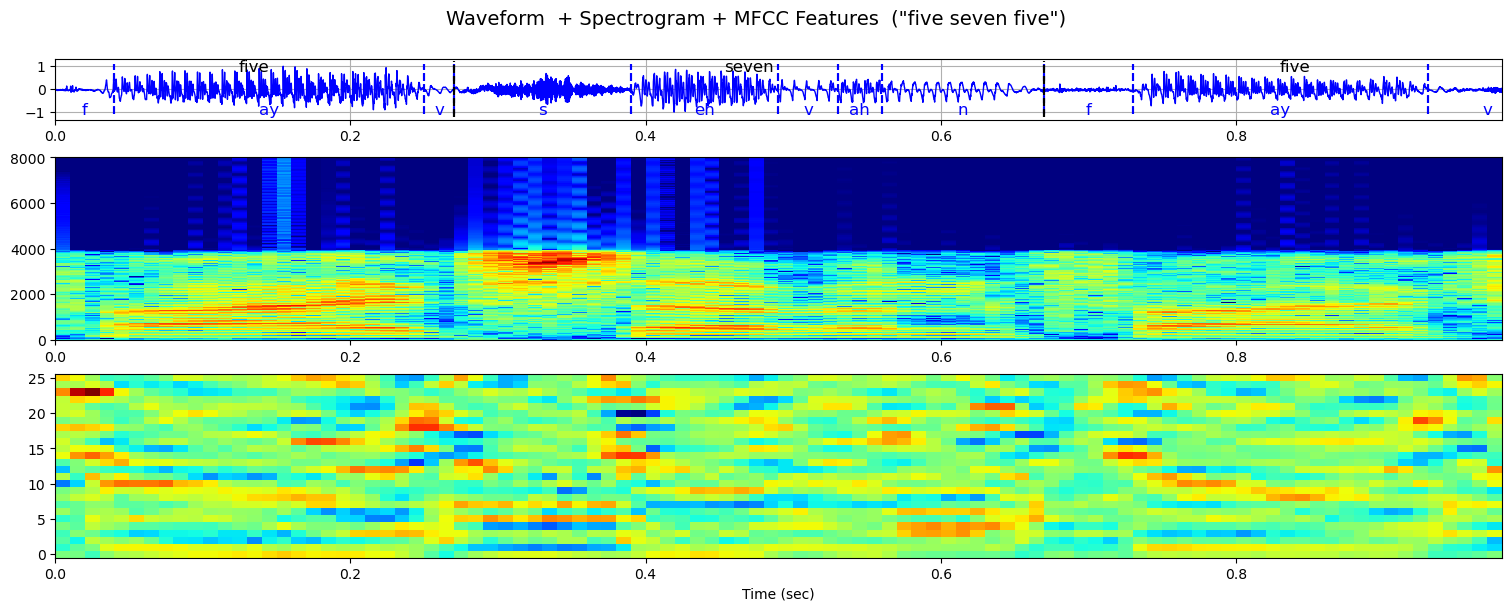

In [22]:
#########################
#1. Select Acoustic Model
#########################
if MODEL_TYPE == "DNN":
    acoustic_model = dnn_model
    nftrs = dnn_nftrs
elif MODEL_TYPE == "GMM":
    acoustic_model = gmm_model
    nftrs = gmm_nftrs


#######################################################
# 2. Load file, transcripts and compute MFCC features
#######################################################
# load the full sentence data 
wavdata_utt, sr, spgdata_utt, ftrs_utt, txt_utt, seg_wrd_utt, seg_phn_utt = get_test_file(file_id,feature_args=feature_args)
delta_f = (sr/2)/(spgdata_utt.shape[0]-1)
shift=feature_args['f_shift']
# only keep the required number of features from the default MFCC-39
ftrs_utt=ftrs_utt[:nftrs,:]
n_frames_utt = ftrs_utt.shape[1]
# transcript holds the sequence of phones in the reference transcription
# labels is the equivalent as a frame level sequence
transcript_utt = seg_phn_utt['seg'].tolist()
labels_utt = pyspch.seg2lbls(seg_phn_utt, n_frames=n_frames_utt,pad_lbl='sil')

#####################################################################################
# 2.b Extract SELECTED fragment from the full utterance
#    -> full utterance in wavdata_utt, spgdata_utt, ..
#    -> selected data in wavdata, spgdata, ..  with time rebased at 0.0
#####################################################################################
if selection_times is None:
    selection_times = np.array([0.,float(len(wavdata_utt)-1)/float(sr)])
# time and frame references of PROCESS part wrt full utterance
frames= (selection_times* (1./shift) ).astype('int')
samples = (selection_times*sr).astype('int')
sample_slice = slice(samples[0],samples[1],1)
frame_slice = slice(frames[0],frames[1],1)
n_frames = frames[1]-frames[0]
times = selection_times

time_ax = np.arange(0,n_frames)*shift+0.5*shift
wavdata = wavdata_utt[sample_slice]
spgdata = spgdata_utt[:,frame_slice]
ftrs = ftrs_utt[:,frame_slice]
#
seg_phn = seg_phn_utt[(seg_phn_utt['t0']<(frames[1]-1)*shift) & (seg_phn_utt['t1']>(frames[0]+1)*shift)].reset_index(drop=True)
seg_phn['t0'] = seg_phn['t0']-selection_times[0]
seg_phn['t1'] = seg_phn['t1']-selection_times[0]
seg_phn['t0'][0]= 0.0
seg_wrd = seg_wrd_utt[(seg_wrd_utt['t0']<(frames[1]-4)*shift) & (seg_wrd_utt['t1']>(frames[0]+4)*shift)].reset_index(drop=True)
seg_wrd['t0'] = seg_wrd['t0']-selection_times[0]
seg_wrd['t1'] = seg_wrd['t1']-selection_times[0]
seg_wrd['t0'][0]= 0.0
#
transcript = seg_phn['seg'].tolist()
labels = pyspch.seg2lbls(seg_phn, n_frames=ftrs.shape[1],pad_lbl='sil')
labels_df = pd.DataFrame({'t':time_ax,'lbl':labels})
txt = " ".join(seg_wrd['seg'])

#################################################################################################
# 3. SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=spgdata,dy=delta_f, #frames=frames,
                                  sample_rate=sr, figsize=(15,6), img_ftrs=[ftrs])
fig.add_seg_plot(seg_phn, iax=0, ypos=.1, color='b',size=12) 
fig.add_seg_plot(seg_wrd, iax=0, ypos=.9, color='k',size=12)
fig.suptitle("Waveform  + Spectrogram + MFCC Features  (\"%s\")\n" %(txt),size=14)
display(fig)
display(Audio(data=wavdata,rate=sr))

### Frame Recognition

As a preliminary task we provide frame recognition.  This gives an idea of how well the utterance matches the given transcript for the model used.   
 
1. compute the class probabilities for each given feature vector
2. recognize by finding the maximum amongst all classes

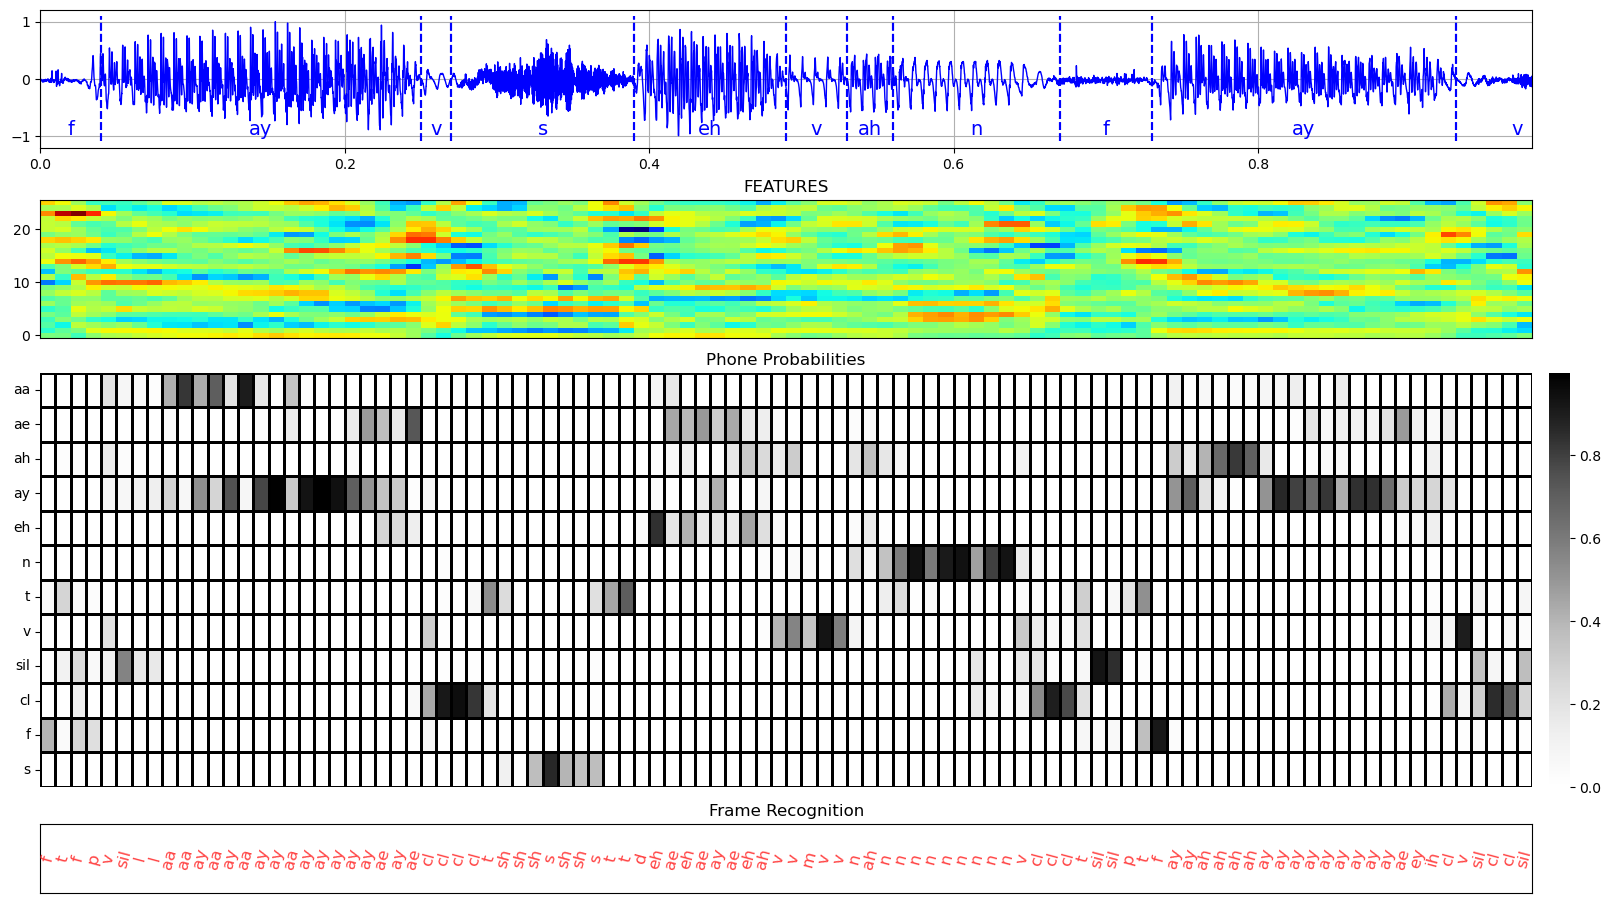

Frame Level Agreement with Reference after Frame Recognition(41/98): 41.84 %


In [23]:
# 1. Compute Frame Based Posteriors
frame_proba = acoustic_model.predict_proba(ftrs.T)

# 2. Frame Recognition = Find the maximum amongst the classes
y_frame_idx = np.argmax(frame_proba, axis=1)
y_frame_lab = [phn_set[i] for i in y_frame_idx]
y_frame_ldf = pd.DataFrame({'t':time_ax,'lbl':y_frame_lab})

# 3. Measure Recognition Rate
n_corr = np.sum([y_frame_lab[i] == labels[i] for i in range(n_frames) ])

# 4. Illustrate: show the outputs of the most likely phones and at least all phones in the transcript, resorted for order in alphabet
top_k = TOP_K
indx_sel = np.argsort(np.sum(frame_proba,axis=0))[::-1][0:top_k]
indx_sel = np.sort(indx_sel)
phn_sel = [phn_set[i] for  i in indx_sel]
phn_sel,indx_sel = select_phones_idx((phn_sel,transcript),phn_set,SORTED=False)
#
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,.5],
            sample_rate=sr, figsize=(16,9),  img_ftrs=[None,None],img_labels=[None,None])

(iax_wav, iax_ftr, iax_prob, iax_frame) = (0,1,2,3)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.axes[iax_ftr].set_title("FEATURES")
fig.axes[iax_ftr].set_xticks([])
plot_probs(frame_proba[:,indx_sel], phn_sel,fig=fig, cmap='Greys',iax=iax_prob, style="img",title="Phone Probabilities") 
fig.add_seg_plot(y_frame_ldf,iax=iax_frame,ypos=.5,color='#F44',size=12,txtargs={'rotation':75},title="Frame Recognition")

fig.axes[iax_frame].set_xticks([])
fig.axes[iax_frame].set_xlabel("")
display(fig)

print("Frame Level Agreement with Reference after Frame Recognition(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames ) )

## 3. Viterbi Alignment
With a Viterbi Alignment we can align a given observation stream (feature vectors) against an HMM graph consisting of states (phones) and arcs (describing the possible transitions).
For the computations we use a TRELLIS, i.e. a matrix with time (observations) on the x-axis and HMM states on the y-axis.    
Each cell in a trellis contains the likelihood to be in a state 'S' at a given time 't' given the observation stream up to time 't.

When the exact transcription is known then the HMM graph takes the form of a strict left-to-right arrangement of HMM states .  The graph may of course also be constructed to accept  multiple words / sentences / pronunciations ... correponding to any speech recognition problem.   In this notebook, the basis is always a phone sequence that is used to construct aleft-to-right graph and on top of that a number of arcs can be added and/or initial and end states can be redefined.

A trellis is a good and efficient way to organize computations for small and moderate sized problems that we deal with here.  

### Computations
The computations involve following steps:   
1. compute the observation probabilities for each state given the feature vector (we compute the likelihoods indirectly from the probabilities used for frame recognition)
2. fill the trellis from left-to-right
3. Finalize: at the end of the observation stream you select the state with the highest likelihood to indicate the ending state.  However, you should only consider states that are ADMISSIBLE ending states (this is part of your graph definition)
4. Find the Viterbi alignment by backtracking on the trellis
 

In [24]:
if SKIP is False: skip = 0.0
else: skip = SKIP
glue =  'sil' if ADD_SIL_BETWEEN else None
if REFERENCE == "MANUAL":  phone_seq = transcript
elif REFERENCE == "CANONICAL": phone_seq = wrds_2_phns(seg_wrd['seg'],lexicon=lexicon, glue=glue)
else: phone_seq = REFERENCE
# add closure state in front of every plosive
if ADD_CL and (REFERENCE!="MANUAL"):
    new_states = []
    for s in phone_seq:
        if s in ['p','t','k','b','d','g']: new_states.append('cl')
        new_states.append(s)
    phone_seq = new_states
# add silence at beginning and end
if ADD_SIL_END:
    phone_seq = ['sil'] + phone_seq + ['sil']
#print(phone_seq)    
obs_indx, trans_mat,init_mat,end_states = make_hmm(phone_seq,phn_set,l2r=1.0,skip=skip,extra_arcs=extra_arcs)
# Add labels of the type Si:S_label to distinguish clearly between state number in graph and acoustic phone model that this is referring to
# used in Hmm-graph viz and trellis 
state_labels = [ "S"+str(i)+":"+phone_seq[i] for i in range(len(phone_seq)) ]
state_labels_S = [ "S"+str(i) for i in range(len(phone_seq)) ]

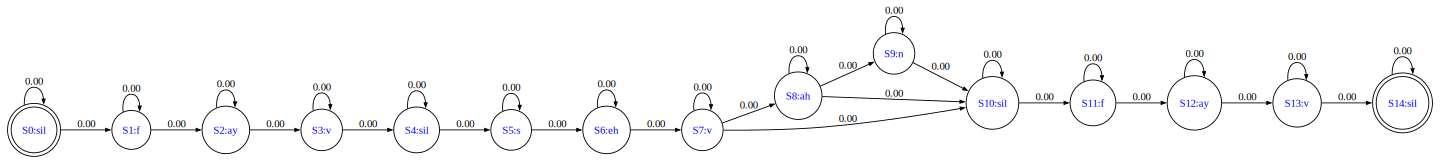

In [25]:
# HMMs work with "observation" likelihoods that are either given directly or
# that can be computed (up to a scaling factor) from the posterior probabilities 
# model class priors are used for correct conversion from posteriors to (scaled) likelihoods
# For scaling/numerical purposes we do all computations with log-likelihoods / log-probabilities

frame_lik = proba_2_prob(frame_proba,priors=gmm_model.class_prior_)
log_lik = Spch.logf(frame_lik)
hmm1 = libhmm.HMM(prob_style="lin",obs_indx=obs_indx,obs_model=None,states=state_labels,transmat=trans_mat,initmat=init_mat,end_states=end_states)
# we constructed the HMM graph with 'linear' probabilities, now we convert everything to log-probs
hmm1.set_probstyle('log')
# draw the graph here
g = hmm1.draw(PROBS=True,fmt="{:.2f}")
#for printing, rendering (pdf) or just viewing 
#print(g)
g.render()
display(g)

In [26]:
trellis1=libhmm.Trellis(hmm1,Normalize=True)
trellis1.viterbi_pass(log_lik)
# recognize from the trellis
y_vit_trel = trellis1.backtrace()
#y_vit_lbl = hmm1.states[y_vit_trel]
y_vit_lbl = [ hmm1.states[k].split(":",1)[1] for k in trellis1.backtrace()]
y_vit_ldf = pd.DataFrame({'t':time_ax,'lbl':y_vit_lbl})
y_vit_seg = Spch.lbls2seg(y_vit_lbl)
n_corr = np.sum([y_vit_lbl[i] == labels[i] for i in range(len(y_vit_lbl))])
print("Frame level agreement with reference after Viterbi(%d/%d): %.2f %%" % (n_corr,n_frames,100.*n_corr/n_frames) )

Frame level agreement with reference after Viterbi(88/98): 89.80 %


## OVERVIEW PLOT for the FULL SEGMENT


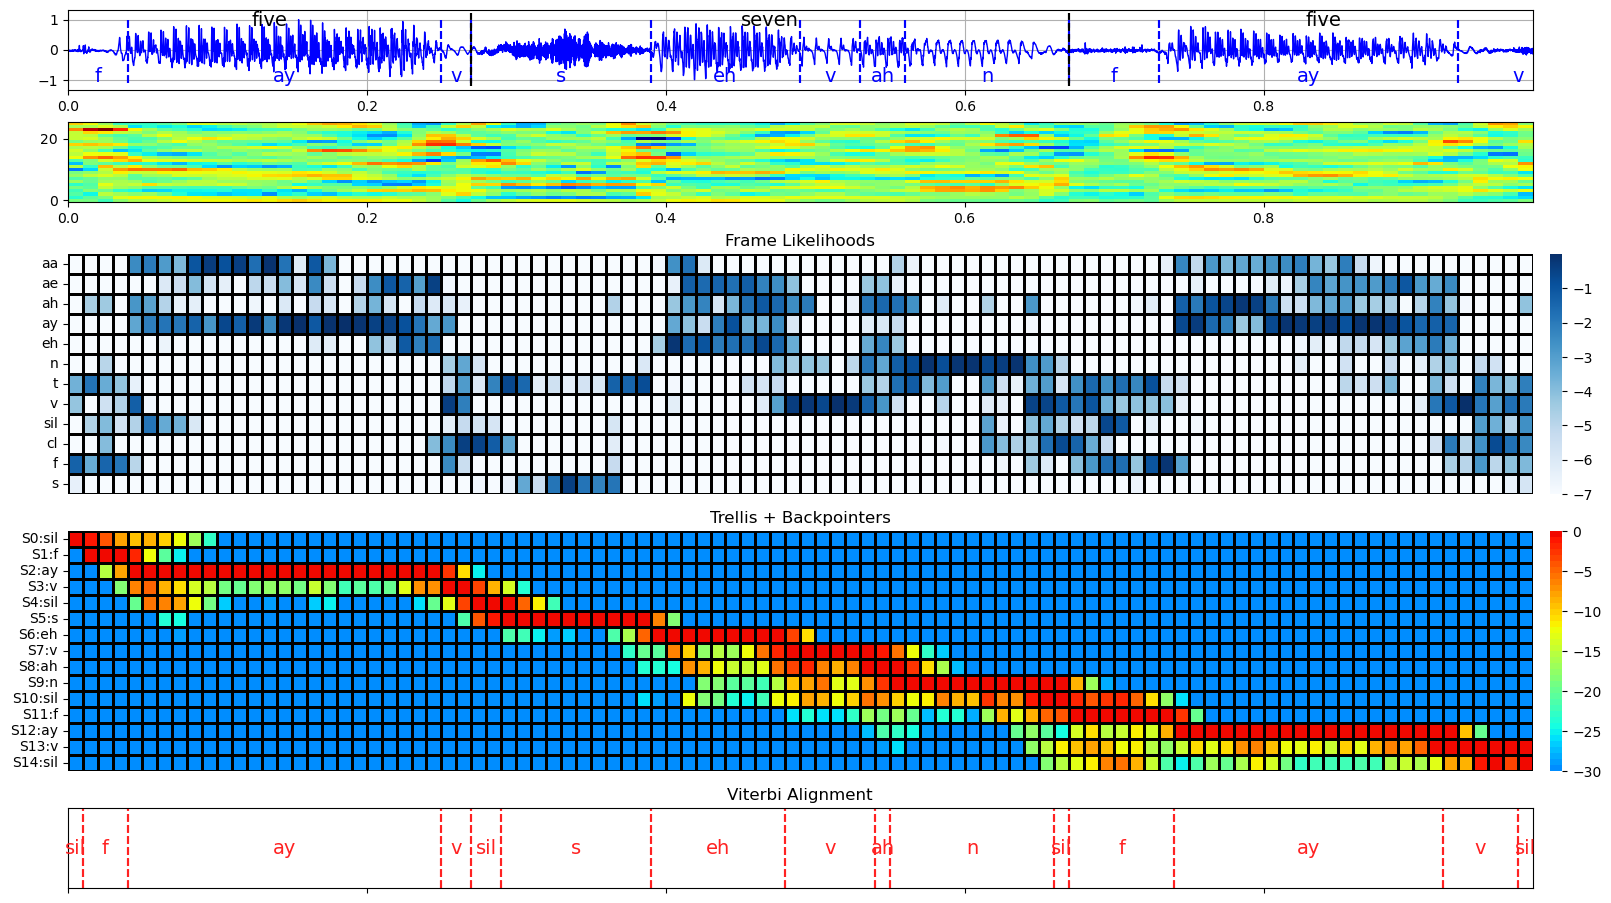

In [89]:
#
ANNOT =  "BACKPTRS" # must be BACKPTRS, VALUES or None
#ANNOT = "VALUES"
ANNOT = None
fig = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,1],
            sample_rate=sr, figsize=(16,9), img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftrs, iax_prob,  iax_trel, iax_vit ) = (0,1,2,3,4)
fig.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='b',size=14) 
fig.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
#
plot_probs(log_lik[:,indx_sel],phn_sel,fig=fig, cmap='Blues',iax=iax_prob,title="Frame Likelihoods",
          vmin=-7, style="img" ) # style="lin",yrange=[.,0]  )
#
trel_probs = trellis1.probs
bp_labels = make_bplabels(trellis1.backptrs,state_labels_S)
if ANNOT is None:    kwargs = {}
elif ANNOT == "BACKPTRS": kwargs = { 'annot' : bp_labels.T, 'annot_kws':{'fontsize':8}, 'fmt':'' }
elif ANNOT == "VALUES": kwargs = { 'annot' : True, 'fmt':'.0f' }
plot_probs(trellis1.probs,fig=fig,cmap=cmap_jet2,labels=state_labels,iax=iax_trel,title="Trellis + Backpointers",
          style="img",vmin=-30,**kwargs) 
fig.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.5,color='#F22',size=14,title="Viterbi Alignment")
display(fig)

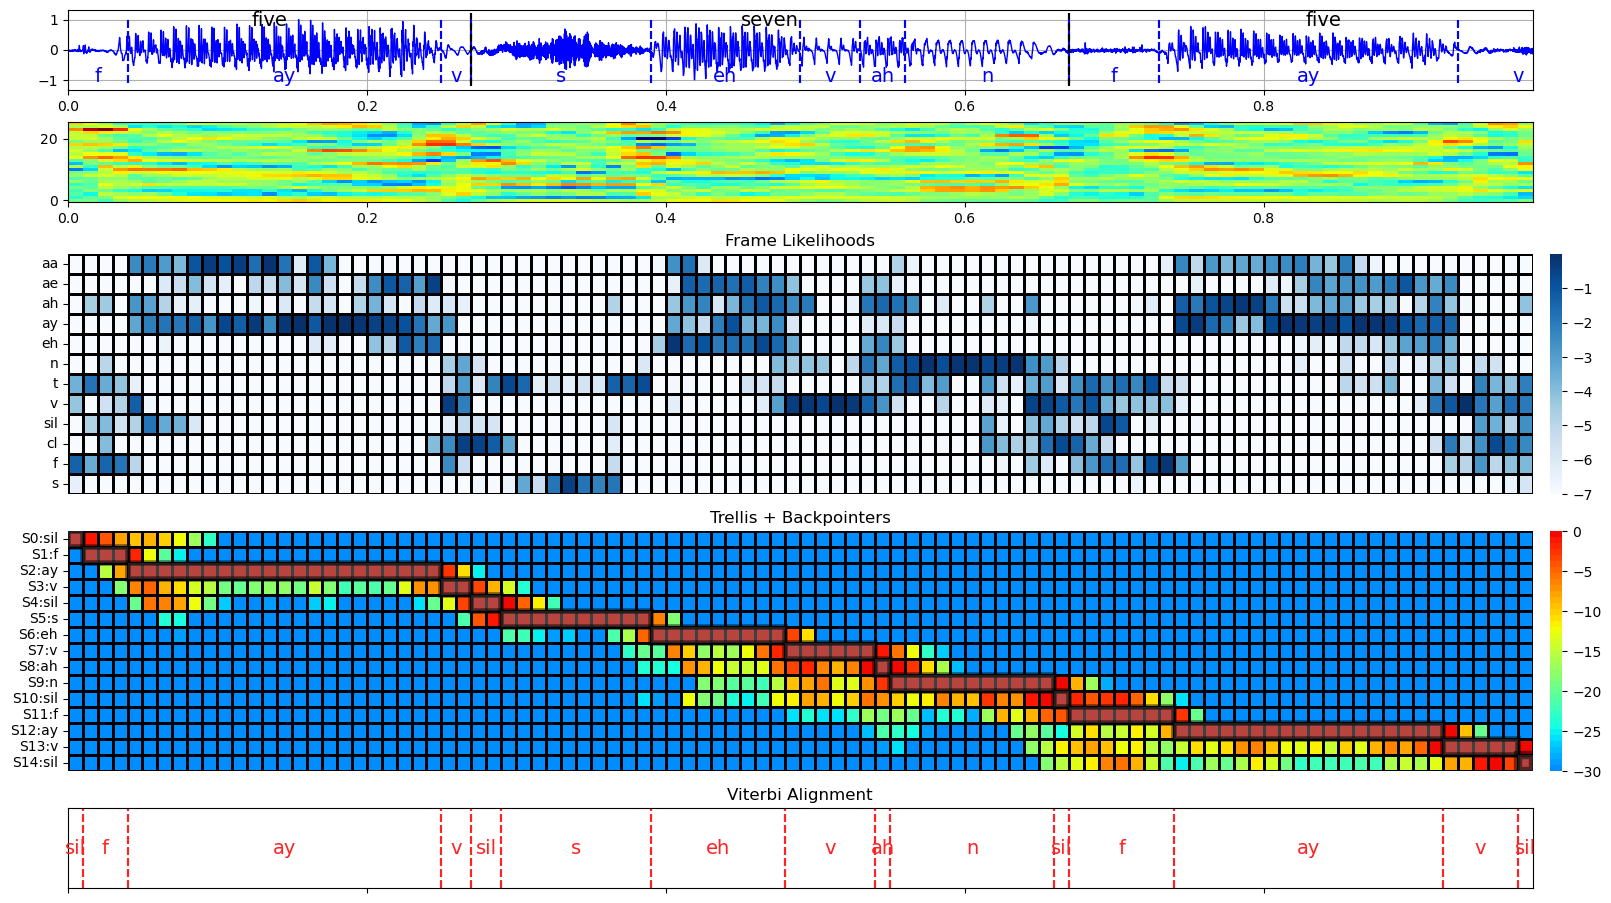

In [90]:
# Add Viterbi alignment as patch to figure
ax_trel = fig.axes[iax_trel]
ifr_start = 0
for ifr in range(1,n_frames):
    if y_vit_trel[ifr] != y_vit_trel[ifr-1]:
        ax_trel.add_patch(Rectangle((ifr_start,y_vit_trel[ifr-1]), ifr-ifr_start, 1, ec='black', fc='grey',alpha=.5,  lw=4)) 
        ifr_start = ifr        
ax_trel.add_patch(Rectangle((ifr_start,y_vit_trel[n_frames-1]), ifr+1-ifr_start, 1, ec='black', fc='grey',alpha=.5, lw=6)) 
display(fig)

### DETAILED VIEW with MORE INFORMATION 
- cells are filled with numbers
- Adjust VIEW_FRAMES and VIEW_PHONES to get a zoomed in view
- OBS_STYLE=1 shows observation probabilities in a matrix corresponding to the trellis   
           =2 shows observation probabilities in as provided by frame recognizer 

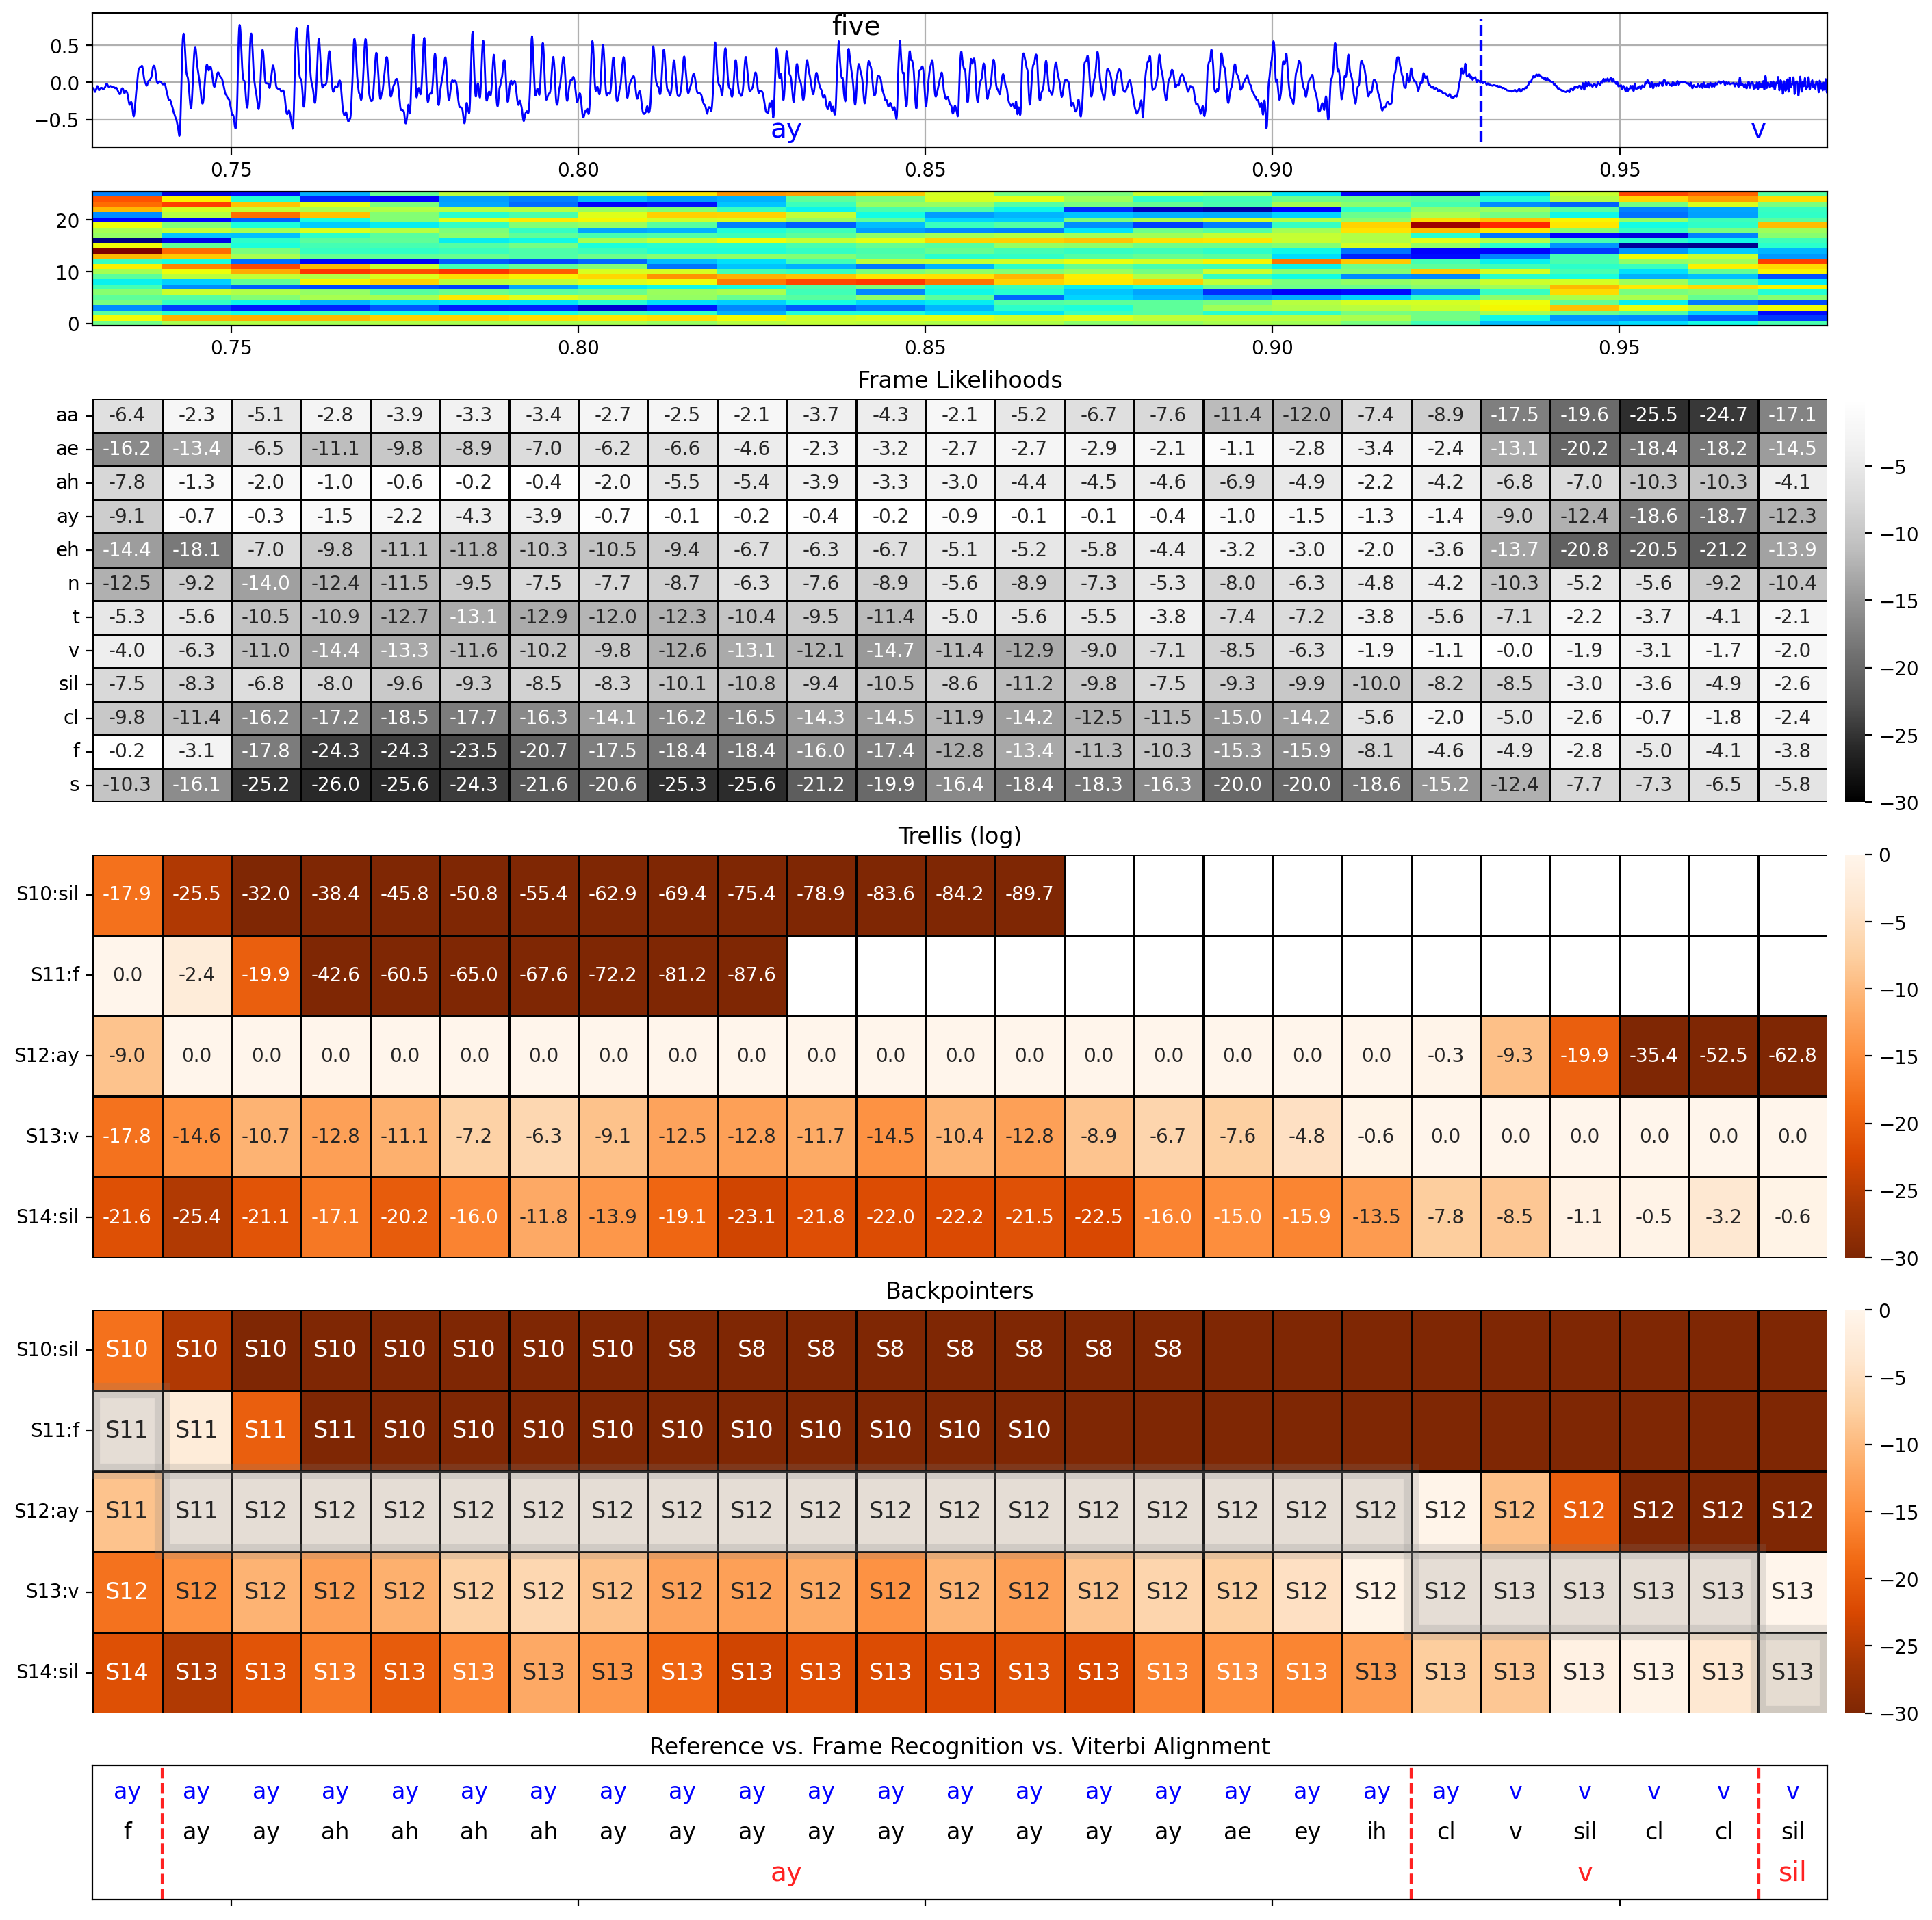

In [76]:
#
OBS_STYLE = 2
len_seq = len(phone_seq)
VIEW_FRAMES = slice(n_frames-25, n_frames)
VIEW_PHONES = slice(len_seq - 5, len_seq,1)
#VIEW_FRAMES = slice(0,30,1)
#VIEW_PHONES = slice(0,7,1)
#VIEW_FRAMES = slice(0,n_frames,1)
#VIEW_PHONES = slice(0,len_seq,1)
#
show_labels = state_labels   # state_labels or state_labels_S
#
fig2 = pyspch.display.PlotSpgFtrs(wavdata=wavdata, spgdata=ftrs,spglabel="",dy=1,row_heights=[1,1,3,3,3,1],
            frames=[VIEW_FRAMES.start, VIEW_FRAMES.stop],
            sample_rate=sr, figsize=(14,14), dpi=200, img_ftrs=[None,None],img_labels=[None,None])
#
(iax_wav, iax_ftrs, iax_prob,  iax_trel, iax_bptr, iax_vit ) = (0,1,2,3,4,5)
fig2.add_seg_plot(seg_phn, iax=iax_wav, ypos=.1, color='b',size=14) 
fig2.add_seg_plot(seg_wrd, iax=iax_wav, ypos=.9, color='k',size=14)
show_labels2 = [ show_labels[i] for i in range(VIEW_PHONES.start,VIEW_PHONES.stop) ]
phone_seq2 = [ phone_seq[i] for i in range(VIEW_PHONES.start,VIEW_PHONES.stop) ]
indx_sel2 = [ phn2idx[p] for p in phone_seq2 ]
#
# PLOT 1: Observation Probabilities


if OBS_STYLE == 1:
    mask = (log_lik[VIEW_FRAMES,VIEW_PHONES] < -90.0).T
    kwargs = { 'annot' : True, 'fmt':'.1f' , 'annot_kws':{'fontsize':10}, 'mask':mask }
    plot_probs(log_lik[VIEW_FRAMES,indx_sel2],show_labels2,fig=fig2, cmap='Greys_r',iax=iax_prob,title="Observation Probabilities (log)",
          vmin=-10, style="img" , **kwargs) 
else:
    mask = (log_lik[VIEW_FRAMES,indx_sel] < -90.0).T
    kwargs = { 'annot' : True, 'fmt':'.1f' , 'annot_kws':{'fontsize':10}, 'mask':mask }
    plot_probs(log_lik[VIEW_FRAMES,indx_sel],phn_sel,fig=fig2, cmap='Greys_r',iax=iax_prob,title="Frame Likelihoods",
          vmin=-30, style="img" , **kwargs) 
#
# PLOT 2: Trellis after Forward Pass
mask = (trellis1.probs[VIEW_FRAMES,VIEW_PHONES] < -90.0).T
kwargs = { 'annot' : True, 'fmt':'.1f' , 'annot_kws':{'fontsize':10}, 'mask':mask }
plot_probs(trellis1.probs[VIEW_FRAMES,VIEW_PHONES],fig=fig2,cmap='Oranges_r',labels=show_labels2,iax=iax_trel,title="Trellis (log)",
          style="img",vmin=-30,**kwargs)
#
# PLOT 3: Recognition via Backtracking
bp_labels2 = make_bplabels(trellis1.backptrs,state_labels_S)
kwargs = { 'annot' : bp_labels2[VIEW_FRAMES,VIEW_PHONES].T, 'annot_kws':{'fontsize':12}, 'fmt':'' }
plot_probs(trellis1.probs[VIEW_FRAMES,VIEW_PHONES],fig=fig2,cmap='Oranges_r',labels=show_labels2,iax=iax_bptr,title="Backpointers",
          style="img",vmin=-30,**kwargs) 
#
# PLOT 4: Frame Recognition and Viterbi Alignment
fig2.add_seg_plot(labels_df,iax=iax_vit,ypos=.8,color='b',size=12)
fig2.add_seg_plot(y_frame_ldf,iax=iax_vit,ypos=.5,color='k',size=12)
fig2.add_seg_plot(y_vit_seg,iax=iax_vit,ypos=.2,color='#F22',size=14,title="Reference vs. Frame Recognition vs. Viterbi Alignment")
ax_probs = fig2.axes[iax_bptr]
ifr_start = VIEW_FRAMES.start
for ifr in range(VIEW_FRAMES.start+1,VIEW_FRAMES.stop):
    if y_vit_trel[ifr] != y_vit_trel[ifr-1]:
        ax_probs.add_patch(Rectangle((ifr_start-VIEW_FRAMES.start,y_vit_trel[ifr-1]-VIEW_PHONES.start), ifr-ifr_start, 1, ec='grey', fc='grey', alpha=.2, lw=8)) 
        ifr_start = ifr        
ax_probs.add_patch(Rectangle((ifr_start-VIEW_FRAMES.start,y_vit_trel[ifr]-VIEW_PHONES.start), ifr+1-ifr_start, 1, ec='grey', fc='grey',alpha=.2, lw=8)) 
display(fig2)

## ===============================

##### Frame number vs. time :  
FRAME counting starts at 0   
FRAME 'i'  corresponds to times : '\[i*0.01, (i+1)*0.01\]sec'

### Questions for EXERCISE2

##### Q1.  Look at the detailed views for the beginning of the utterance (first 30 frames)
Try to understand what happens in frame 4   
    - if you make a decision based on the current frame and its past only and don't let the future influence your decision, which phones have you recognized so far ?   
    - what changes if you do a Viterbi alignment based on the full word   
    - At least how many phonemes scored better than the ultimately recognized 'ah' when just looking at the frame based scores ?   


##### Q2. Look at the end of the utterance (last 20 frames)
1.   Answer the questions below with following understanding. You were trying to distinguish between compute / computer / computers and assumed that the recording ended in SILENCE
    - If you play the full recording and terminate in the last frame, what word have you recognized   
    - What word did you recognize if the recording was terminated at frame 42 or 44 ?   
   
2. Answer the above questions again if you do NOT impose SILENCE as last state